<a href="https://colab.research.google.com/github/Ilian10Janopullo/Machine-Learning-Project/blob/main/Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random Forest

Loading and validating data...
Target Statistics:
count    239747.000000
mean         73.310217
std         134.261774
min           0.000000
25%           0.000000
50%           0.000000
75%          61.154920
max         542.347580
Name: Electric Range (km), dtype: float64

Running leakage detection...

Checking for data leakage...
Highly correlated features (>0.95): ['Vehicle Age', 'Make_BMW', 'Model_500', 'Model_AIR', 'Model_CITY', 'Model_CX-90', 'Model_HORNET', 'Model_I-PACE', 'Model_LYRIQ', 'Model_OCEAN', 'Model_ONE', 'Model_OUTLANDER', 'Model_PACIFICA', 'Model_PROMASTER 3500', 'Model_PS2', 'Model_REVUELTO', 'Model_SOLTERRA', 'Model_SPECTRE', 'Model_TONALE', 'Model_TRANSIT CONNECT ELECTRIC', 'Model_VF 8', 'Model_WHEEGO', 'Model_ZEVO', 'Electric Utility_BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||BIG BEND ELECTRIC COOP, INC', 'Electric Utility_BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||PUD NO 1 OF ASOTIN COUNTY', 'Electric Utility_BONNEVILLE POWER ADMINISTRATION||ORCAS POWER 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   55.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s



Evaluating model...


[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.3s finished



Validation Metrics:
RMSE: 10.93
MAE: 3.51
R²: 0.99
Max Error: 239.05
Median Absolute Error: 0.02
Within 10% Error: 80.7%
Within 20% Error: 93.1%
Exact Predictions: 0.0%


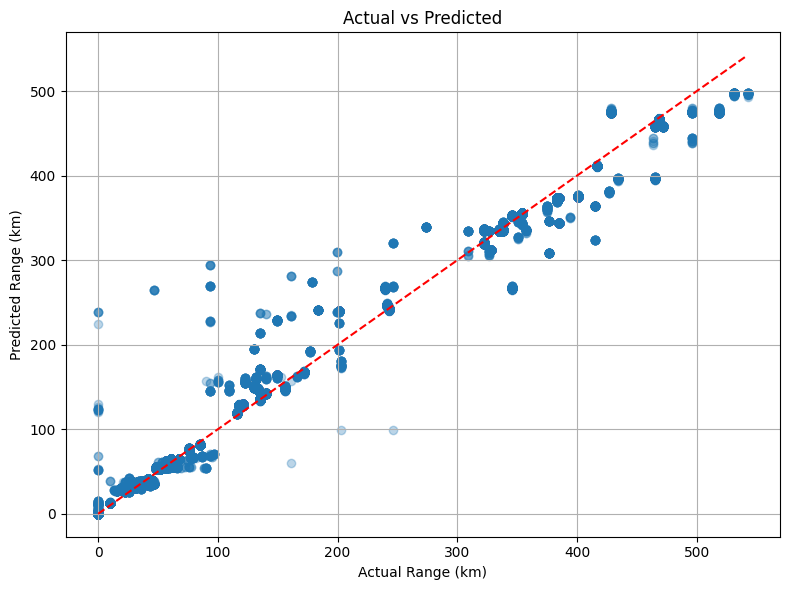

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# 1. Data Loading with Strict Validation
def load_data():
    data = pd.read_csv('/content/processed_ev_data (1).csv', low_memory=False)

    # Verify target exists and has realistic values
    target = 'Electric Range (km)'
    assert target in data.columns, f"Target column '{target}' not found"

    # Check for suspicious target values
    target_stats = data[target].describe()
    print("Target Statistics:")
    print(target_stats)

    if target_stats['std'] < 5:
        raise ValueError("Target variance too low - possible preprocessing error")
    if data[target].nunique() < 100:
        print(f"WARNING: Only {data[target].nunique()} unique target values")

    return data

# 2. Advanced Leakage Detection
def detect_leakage(data, target_col):
    print("\nChecking for data leakage...")

    # 1. Check for duplicate features
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    duplicates = [column for column in upper.columns if any(upper[column] > 0.95)]
    if duplicates:
        print(f"Highly correlated features (>0.95): {duplicates}")

    # 2. Check feature-target correlation
    high_corr = data.corr()[target_col].abs().sort_values(ascending=False)
    print("\nTop correlated features with target:")
    print(high_corr.head(10))

    # 3. Suggest features to remove
    to_remove = high_corr[high_corr > 0.9].index.tolist()
    if target_col in to_remove:
        to_remove.remove(target_col)
    if to_remove:
        print(f"\nSuggested removal (correlation >0.9): {to_remove}")

    return to_remove

# 3. Model Training with Strict Settings
def train_model(X_train, y_train):
    model = RandomForestRegressor(
        n_estimators=150,        # Reduced complexity
        max_depth=8,             # Shallower trees
        min_samples_split=20,    # More samples required to split
        min_samples_leaf=10,     # More samples required at leaves
        max_features=0.3,        # Fewer features considered
        bootstrap=True,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    print("\nTraining model with strict regularization...")
    model.fit(X_train, y_train)
    return model

# 4. Robust Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate error percentages
    error_percentage = 100 * abs(y_test - y_pred) / y_test
    error_percentage = error_percentage[y_test > 0]  # Exclude zero-range vehicles

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
        'Max Error': max(abs(y_test - y_pred)),
        'Median Absolute Error': np.median(abs(y_test - y_pred)),
        'Within 10% Error': np.mean(error_percentage <= 10),
        'Within 20% Error': np.mean(error_percentage <= 20),
        'Exact Predictions': np.mean(y_test == y_pred)
    }

    print("\nValidation Metrics:")
    for name, value in metrics.items():
        if '%' in name or 'Exact' in name or 'Within' in name:
            print(f"{name}: {value:.1%}")
        else:
            print(f"{name}: {value:.2f}")

    # Only Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Range (km)')
    plt.ylabel('Predicted Range (km)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics


# Main Execution
def main():
    print("Loading and validating data...")
    data = load_data()

    print("\nRunning leakage detection...")
    target_col = 'Electric Range (km)'
    to_remove = detect_leakage(data, target_col)

    # Prepare data - removing high-correlation features
    X = data.drop(columns=[target_col] + to_remove)
    y = data[target_col]

    # Verify we have features left
    if X.shape[1] == 0:
        raise ValueError("All features removed - check leakage detection")

    print(f"\nUsing {X.shape[1]} features after leakage removal")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Larger test size

    print("\nTraining model...")
    model = train_model(X_train, y_train)

    print("\nEvaluating model...")
    metrics = evaluate_model(model, X_test, y_test)

    # # Final validation
    # if metrics['R²'] > 0.98 or metrics['Exact Predictions'] > 0.1:
    #     print("Recommend checking:")
    #     print("- Target variable calculation")
    #     print("- Time-based leakage")
    #     print("- Feature engineering steps")
    # else:
    #     print("\nModel validation passed")
    #     os.makedirs('saved_models', exist_ok=True)
    #     joblib.dump(model, 'saved_models/rf_model_validated.pkl')
    #     print("Model saved as 'rf_model_validated.pkl'")

if __name__ == "__main__":
    main()

# XGBoost


Target Summary:
count    239747.000000
mean         73.310217
std         134.261774
min           0.000000
25%           0.000000
50%           0.000000
75%          61.154920
max         542.347580
Name: Electric Range (km), dtype: float64

Running leakage checks...
Top correlated features:
Clean Alternative Fuel Vehicle (CAFV) Eligibility_Eligibility unknown as battery range has not been researched    0.662971
Model Year                                                                                                        0.532359
Vehicle Age                                                                                                       0.532359
Model_MODEL S                                                                                                     0.271590
Model_BOLT EV                                                                                                     0.261441
Model_MODEL 3                                                                              

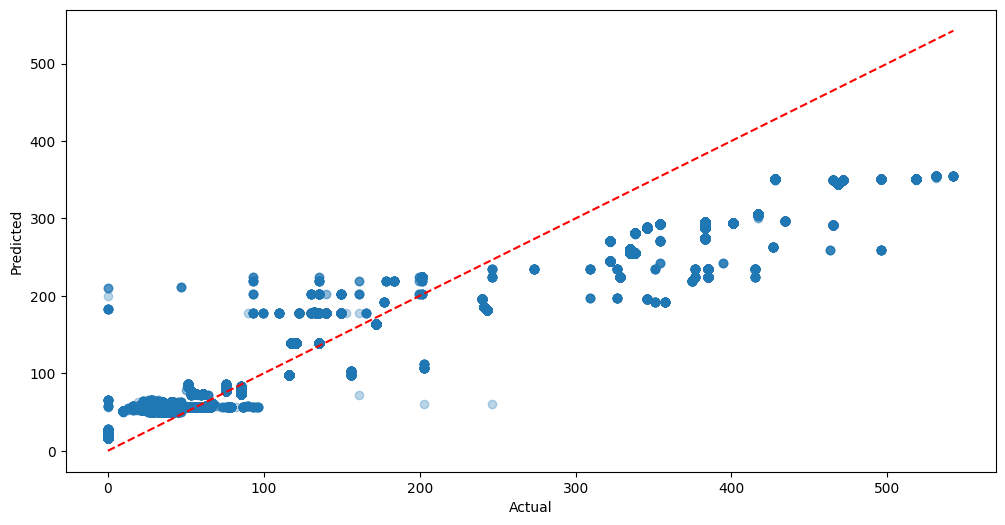

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
import joblib
import os

# 1. Data Loading with Advanced Validation
def load_and_validate():
    data = pd.read_csv('/content/processed_ev_data (1).csv')

    # Target validation
    target = 'Electric Range (km)'
    print("Target Summary:")
    print(data[target].describe())

    # Check for problematic distributions
    if data[target].nunique() < 100:
        print(f"\nWARNING: Only {data[target].nunique()} unique target values")
        print("Top target values:")
        print(data[target].value_counts().head(10))

    return data

# 2. Leakage Detection
def detect_leakage(data, target):
    X = data.drop(columns=[target])
    y = data[target]

    print("\nRunning leakage checks...")

    # Check feature correlations
    corr = X.corrwith(y).abs().sort_values(ascending=False)
    print("Top correlated features:")
    print(corr.head(10))

    # Suggest features to remove
    to_remove = corr[corr > 0.9].index.tolist()
    if to_remove:
        print(f"\nSuggest removing these high-correlation features: {to_remove}")

    return to_remove

# 3. Model Training with Strict Settings
def train_model(X_train, y_train, X_test, y_test):
    print("\nTraining with strict parameters...")
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=150,  # Reduced
        max_depth=3,       # Very conservative
        learning_rate=0.01,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=2,
        reg_lambda=2,
        random_state=42,
        early_stopping_rounds=20
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=10
    )
    return model

# 4. Rigorous Evaluation
def evaluate(model, X, y):
    y_pred = model.predict(X)

    # Basic metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
        'MAE': mean_absolute_error(y, y_pred),
        'R²': r2_score(y, y_pred),
        'Median Error': np.median(np.abs(y - y_pred))
    }

    # Permutation importance
    print("\nCalculating permutation importance...")
    perm_importance = permutation_importance(
        model, X, y, n_repeats=5, random_state=42, n_jobs=-1
    )

    # Combine metrics
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    top_features = pd.DataFrame({
        'feature': X.columns[sorted_idx][:10],
        'importance': perm_importance.importances_mean[sorted_idx][:10]
    })

    return metrics, top_features

def main():
    # Setup
    os.makedirs('saved_models', exist_ok=True)

    # 1. Load and validate
    data = load_and_validate()

    # 2. Detect leakage
    target = 'Electric Range (km)'
    to_remove = detect_leakage(data, target)

    # 3. Prepare data
    X = data.drop(columns=[target] + to_remove)
    y = data[target]

    if X.shape[1] == 0:
        raise ValueError("All features removed - check leakage detection")

    print(f"\nUsing {X.shape[1]} features")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # 4. Train model
    model = train_model(X_train, y_train, X_test, y_test)

    # 5. Evaluate
    metrics, importance = evaluate(model, X_test, y_test)

    print("\nFinal Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    print("\nTop Predictive Features:")
    print(importance)

    # 6. Visual Diagnostics
    plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    plt.scatter(y_test, model.predict(X_test), alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # plt.subplot(1, 2, 2)
    # plt.barh(importance['feature'], importance['importance'])
    # plt.xlabel('Permutation Importance')
    # plt.tight_layout()
    # plt.show()
    # Only Actual vs Predicted Plot
if __name__ == "__main__":
    main()